In [10]:
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video

In [14]:
from pathlib import Path

BASE_DIR = Path.home() / "Desktop" / "Data"
REAL_DIR = BASE_DIR / "Celeb-real"
FAKE_DIR = BASE_DIR / "Celeb-synthesis"
YOUTUBE_DIR = BASE_DIR / "Youtube-real"

print("REAL_DIR exists:", REAL_DIR.exists())
print("FAKE_DIR exists:", FAKE_DIR.exists())
print("YOUTUBE_DIR exists:", YOUTUBE_DIR.exists())

REAL_DIR exists: True
FAKE_DIR exists: True
YOUTUBE_DIR exists: True


In [15]:
def list_videos(folder):
    videos = [f for f in folder.rglob("*") if f.suffix.lower() in [".mp4", ".avi", ".mov"]]
    print(f"{folder.name}: {len(videos)} videos")
    return videos

real_videos = list_videos(REAL_DIR)
fake_videos = list_videos(FAKE_DIR)
yt_videos = list_videos(YOUTUBE_DIR)


Celeb-real: 590 videos
Celeb-synthesis: 5639 videos
Youtube-real: 300 videos


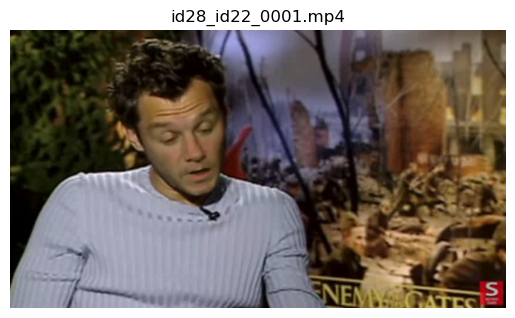

In [17]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

def show_sample_frame(video_path):
    cap = cv2.VideoCapture(str(video_path))
    ret, frame = cap.read()
    cap.release()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.imshow(frame)
        plt.title(video_path.name)
        plt.axis('off')
        plt.show()
    else:
        print("❌ Failed to read video:", video_path)

show_sample_frame(fake_videos[1])


In [18]:
pip install facenet-pytorch opencv-python pillow tqdm

Note: you may need to restart the kernel to use updated packages.


In [19]:
REAL_VIDEOS_1 = Path.home() / "Desktop" / "Data" / "Celeb-real"
REAL_VIDEOS_2 = Path.home() / "Desktop" / "Data" / "Youtube-real"
FAKE_VIDEOS = Path.home() / "Desktop" / "Data" / "Celeb-synthesis"

OUT_REAL = Path("face_crops/real")
OUT_FAKE = Path("face_crops/fake")
OUT_REAL.mkdir(parents=True, exist_ok=True)
OUT_FAKE.mkdir(parents=True, exist_ok=True)

def list_videos(folder):
    return [f for f in folder.rglob("*") if f.suffix.lower() in [".mp4", ".avi", ".mov"]]

# Combine both real video sources
real_videos = list_videos(REAL_VIDEOS_1) + list_videos(REAL_VIDEOS_2)
fake_videos = list_videos(FAKE_VIDEOS)

print(f"Total real videos: {len(real_videos)}")
print(f"Total fake videos: {len(fake_videos)}")


Total real videos: 890
Total fake videos: 5639


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mtcnn = MTCNN(image_size=224, margin=20, device=device)


In [21]:
def extract_faces_from_video(video_path, output_dir, num_frames=20):
    cap = cv2.VideoCapture(str(video_path))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if frame_count == 0:
        print(f"⚠️ Skipping {video_path.name} (no frames found)")
        return 0

    sample_idxs = set(np.linspace(0, frame_count - 1, num=num_frames, dtype=int))
    idx = 0
    saved = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx in sample_idxs:
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            face = mtcnn(img)
            if face is not None:
                face_img = face.permute(1, 2, 0).byte().numpy()
                filename = output_dir / f"{video_path.stem}_frame{idx}.jpg"
                Image.fromarray(face_img).save(filename)
                saved += 1
        idx += 1
    cap.release()
    return saved


In [23]:
from tqdm import tqdm

print("🔍 Starting real video face extraction...")
for video in tqdm(real_videos, desc="Extracting real faces"):
    extract_faces_from_video(video, OUT_REAL)

print("🔍 Starting fake video face extraction...")
for video in tqdm(fake_videos, desc="Extracting fake faces"):
    extract_faces_from_video(video, OUT_FAKE)


🔍 Starting real video face extraction...


Extracting real faces: 100%|██████████████████| 890/890 [21:55<00:00,  1.48s/it]


🔍 Starting fake video face extraction...


Extracting fake faces: 100%|██████████████| 5639/5639 [2:30:18<00:00,  1.60s/it]


In [24]:
from pathlib import Path

print("Real face images:", len(list(Path("face_crops/real").glob("*.jpg"))))
print("Fake face images:", len(list(Path("face_crops/fake").glob("*.jpg"))))


Real face images: 17771
Fake face images: 112778


In [25]:
pip install torch torchvision matplotlib


Note: you may need to restart the kernel to use updated packages.


In [28]:
from pathlib import Path
import shutil
import random
import os

random.seed(42)

original_root = Path("face_crops")
target_root = Path("face_crops_split")

# Create folders
for split in ["train", "val", "test"]:
    for cls in ["real", "fake"]:
        os.makedirs(target_root / split / cls, exist_ok=True)

def split_and_copy(cls):
    files = list((original_root / cls).glob("*.jpg"))
    random.shuffle(files)
    n = len(files)
    train_end = int(0.7 * n)
    val_end = int(0.85 * n)

    for f in files[:train_end]:
        shutil.copy(f, target_root / "train" / cls / f.name)
    for f in files[train_end:val_end]:
        shutil.copy(f, target_root / "val" / cls / f.name)
    for f in files[val_end:]:
        shutil.copy(f, target_root / "test" / cls / f.name)

split_and_copy("real")
split_and_copy("fake")


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset
from pathlib import Path

# Paths
DATA_DIR = Path("face_crops_split")
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 3 

# Use Apple M-series GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("🚀 Using device:", device)

# Transforms
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])
}

# Limit dataset size
max_train = 5000
max_val = 1000
max_test = 1000

datasets_dict = {
    'train': Subset(datasets.ImageFolder(DATA_DIR / 'train', transform=transform['train']), range(max_train)),
    'val': Subset(datasets.ImageFolder(DATA_DIR / 'val', transform=transform['val']), range(max_val)),
    'test': Subset(datasets.ImageFolder(DATA_DIR / 'test', transform=transform['test']), range(max_test)),
}

dataloaders = {
    x: DataLoader(datasets_dict[x], batch_size=BATCH_SIZE, shuffle=True)
    for x in ['train', 'val', 'test']
}

# Model setup
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Train
def train_model(model, dataloaders, criterion, optimizer, epochs):
    best_acc = 0.0
    for epoch in range(epochs):
        print(f"\n Epoch {epoch+1}/{epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), "best_deepfake_model.pth")

    print(f"\n Best Validation Accuracy: {best_acc:.4f}")
    return model

model = train_model(model, dataloaders, criterion, optimizer, EPOCHS)

# Final test accuracy
def evaluate_on_test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    print(f"\n Test Accuracy: {100 * correct / total:.2f}%")

evaluate_on_test(model, dataloaders['test'])


🚀 Using device: mps

 Epoch 1/3
------------------------------
Train Loss: 0.0361 | Acc: 0.9872
Val Loss: 0.0028 | Acc: 1.0000

 Epoch 2/3
------------------------------
Train Loss: 0.0018 | Acc: 1.0000
Val Loss: 0.0013 | Acc: 1.0000

 Epoch 3/3
------------------------------
Train Loss: 0.0010 | Acc: 1.0000
Val Loss: 0.0008 | Acc: 1.0000

 Best Validation Accuracy: 1.0000

 Test Accuracy: 100.00%
